In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

import shutil

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

## Configure directories

In [4]:
PATH = 'data/planet'
DS_PATH = '~/development/_training/ml/_datasets/kaggle_planet'

In [5]:
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

!ln -s {DS_PATH}/train-jpg {PATH}/
!ln -s {DS_PATH}/test-jpg {PATH}/
!ln -s {DS_PATH}/train_v2.csv {PATH}/

ln: failed to create symbolic link 'data/planet/train-jpg': File exists
ln: failed to create symbolic link 'data/planet/test-jpg': File exists
ln: failed to create symbolic link 'data/planet/train_v2.csv': File exists


## Build sample dataset

In [6]:
# fetch entire dataset
train_df = pd.read_csv(f'{PATH}/train_v2.csv', index_col=None)
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# build a sample set for testing
shutil.rmtree(f'{PATH}/sample/train-jpg', ignore_errors=True)
shutil.rmtree(f'{PATH}/sample/test-jpg', ignore_errors=True)

os.makedirs(f'{PATH}/sample/train-jpg', exist_ok=True)
os.makedirs(f'{PATH}/sample/test-jpg', exist_ok=True)

sample_df = train_df.sample(n=500)
sample_df.to_csv(f'{PATH}/sample/train_v2.csv', index=None)

In [8]:
for fn in sample_df.image_name:
    shutil.copyfile(f'{PATH}/train-jpg/{fn}.jpg', f'{PATH}/sample/train-jpg/{fn}.jpg')

In [9]:
test_files = random.sample(os.listdir(f'{PATH}/test-jpg'), 250)
for fn in test_files:
    shutil.copyfile(f'{PATH}/test-jpg/{fn}', f'{PATH}/sample/test-jpg/{fn}')

## Utils

In [10]:
# utils
threshold_range = np.arange(start=0.17, stop=0.24, step=0.01)

def f2(preds, targs):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        return max([ fbeta_score(targs, (preds > th), 2, average='samples') for th in threshold_range ])
    
def opt_threshold(preds, targs):
    idx = np.argmax([ fbeta_score(targs, (preds > th), 2, average='samples') for th in threshold_range ])
    return threshold_range[idx]

## Define architecture, dataset, and hyperparameters

In [11]:
PATH = f'data/planet/sample' 
labels_csv = f'{PATH}/train_v2.csv'

arch = resnet34; lr=1e-2; metrics=[f2]

bsz = 64
img_sz = 64

In [12]:
df_train = pd.read_csv(labels_csv, index_col=None)
val_idxs = get_cv_idxs(len(df_train))

In [13]:
def get_data(p_model, img_sz, val_idxs=[0]):
    tfms = tfms_from_model(p_model, img_sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    
    return ImageClassifierData.from_csv(f'{PATH}', 'train-jpg', labels_csv, bs=bsz, tfms=tfms, 
                                        val_idxs=val_idxs, suffix='.jpg', test_name='test-jpg')

## Review the data

In [14]:
data = get_data(arch, 256, val_idxs)

In [15]:
x, y = next(iter(data.val_dl))

In [16]:
y


    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [17]:
list(zip(data.classes, y[0]))

[('agriculture', 0.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

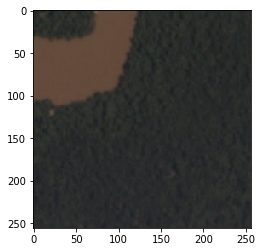

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0] * 0.8)

## Train

In [19]:
# start small
img_sz = 64

In [20]:
data = get_data(arch, img_sz, val_idxs)
data = data.resize(int(img_sz * 1.3), 'tmp')

A Jupyter Widget

In [21]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [ ]:
lrf = learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2

In [ ]:
# more initial fitting needed probably because this dataset is so different from imagenet
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# with data like imagenet, can use multiples of 10 for each lr group
lrs = np.array([lr/9, lr/3, lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{arch.__name__}_{img_sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
# double size
img_sz = 128

In [ ]:
learn.set_data(get_data(arch, img_sz, val_idxs))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{arch.__name__}_{img_sz}')

In [ ]:
# double size again
img_sz = 256

In [ ]:
learn.set_data(get_data(arch, img_sz, val_idxs))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{arch.__name__}_{img_sz}')

In [ ]:
preds, y = learn.TTA()

In [ ]:
f2 = f2(preds, y)
opt_th = opt_threshold(preds, y)

print(f2, opt_th)

In [ ]:
preds, y = learn.TTA(is_test=True)

In [ ]:
pred_labels = [ ' '.join(filter(None, x)) for x in np.where(preds > opt_th, data.classes, '') ]

In [ ]:
preds_df = pd.DataFrame(pred_labels, columns=['tags'])
preds_df.insert(0, 'image_name', [ fn[10:-4] for fn in data.test_ds.fnames ])
preds_df['image_name'] = preds_df['image_name'].str[10:-4]
preds_df.head()

## Train with cross-validation

In [ ]:
def fit_cv_model(val_idxs):
    img_sz = 64; lr = 1e-2
    
    data = get_data(arch, img_sz, val_idxs)
    data = data.resize(int(img_sz * 1.3), 'tmp')
    
    learn = ConvLearner.pretrained(arch, data, metrics=metrics)
    
    # train model
    learn.fit(lr, 1)
    
    return learn

In [ ]:
df_train = pd.read_csv(labels_csv, index_col=None)

skf = StratifiedKFold(5, shuffle=True)

i = 0
for train_idxs, val_idxs in skf.split(df_train.image_name, df_train.tags):
    i += 1
    
    # fit model
    learn = fit_cv_model(val_idxs)
    
    # save validation predictions
    preds_val, y_val = learn.TTA()
    
    th = opt_threshold(preds_val, y_val)
    f2 = f2(preds_val, y_val)
    
    print(f'F2 Score: {f2}, Opt. Threshold: {th}')
    
    val_preds_df = pd.DataFrame(preds_val, columns=data.classes)
    val_preds_df.insert(0, 'image_name', [ fn[10:-4] for fn in data.val_ds.fnames])
    val_preds_df.to_csv(f'{PATH}/{arch.__name__}_kfold_{i}_val_preds.csv', index=None)
    
    # save test predictions
    preds_test = learn.TTA(is_test=True)
    
    test_preds_df = pd.DataFrame(preds_test)
    test_preds_df.insert(0, 'image_name', [ fn[10:-4] for fn in data.test_ds.fnames])
    test_preds_df.to_csv(f'{PATH}/{arch.__name__}_kfold_{i}_test_preds.csv', index=None)

## Submissions

In [ ]:
subm_df = pd.read_csv(f'{DS_PATH}/sample_submission_v2.csv')

In [ ]:
subm_df.head()